## Финальный проект: Прогнозирование оттока клиентов

## Неделя 2: Построение Baseline решения

In [1]:
import pandas as pd
import numpy as np
import random
import os
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
PATH = '.\\telecom_clients_prediction'
test = pd.read_csv(os.path.join(PATH,'orange_small_churn_test_data.csv'), index_col='ID')
train = pd.read_csv(os.path.join(PATH,'orange_small_churn_train_data.csv'), index_col='ID')

In [3]:
print(test.shape)
print(train.shape)

(10000, 230)
(18299, 231)


In [4]:
data = train.drop('labels',axis=1)
target = train['labels']

In [5]:
features_num = data.columns[0:190].tolist()
features_cat = data.columns[190:].tolist()

In [6]:
print(len(features_num))
print(len(features_cat))

190
40


In [7]:
target = pd.DataFrame(target)
target['labels'] = target['labels'].map({-1:0, 1:1})

In [8]:
data = data[:-1]
target = target[:-1]

In [9]:
print(data.shape)
print(target.shape)

(18298, 230)
(18298, 1)


# Доли классов (отток-не отток)

In [215]:
print('churn:', len(target[target['labels']==0])/len(target['labels']))
print('no_churn:', len(target[target['labels']==1])/len(target['labels']))

churn: 0.9247458738659963
no_churn: 0.07525412613400372


# Числовые признаки

In [10]:
data_num = data[features_num]

In [11]:
print(len(data_num.columns[data_num.isnull().sum()>18200])) #признаки с более чем 18200 пропущенными значениями
print(len(data_num.columns[data_num.isnull().sum()>18100]))
print(len(data_num.columns[data_num.isnull().sum()>18000]))
print(len(data_num.columns[data_num.isnull().sum()>16000])) 
print(len(data_num.columns[data_num.isnull().sum()<9000]))
print(len(data_num.columns[data_num.isnull().sum()<1000])) 

19
22
65
148
41
3


In [12]:
set_more_18200 = set(data_num.columns[data_num.isnull().sum()>18200])
set_more_18100 = set(data_num.columns[data_num.isnull().sum()>18100])
set_more_18000 = set(data_num.columns[data_num.isnull().sum()>18000])  
set_more_16000 = set(data_num.columns[data_num.isnull().sum()>16000])
set_less_18000 = set(data_num.columns[data_num.isnull().sum()<18000])  
set_less_9000 = set(data_num.columns[data_num.isnull().sum()<9000])
set_less_1000 = set(data_num.columns[data_num.isnull().sum()<1000])

Удалим признаки с более чем 18000 пропусков.

In [13]:
data_num = data_num[set_less_18000]

Много пропусков. Будем считать корреляции признаков с целевой переменной, как разность мат ожиданий и отберем только те признаки уровень значимости p для которых меньше 0.05 при проверке гипотезы о том, что распределения классов разные

In [14]:
corr_num = data_num[target['labels']==1].mean() - data_num[target['labels']==0].mean() #разность мат ожиданий классов

In [15]:
# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
# H0 - распределения совпадают
# H1 - H0 - неверна
p_values = list()
for i,feat in enumerate(set_less_18000):
    label0 = data_num.loc[target.labels == 0, feat].dropna()
    label1 = data_num.loc[target.labels == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        try:
            p_value = stats.mannwhitneyu(label0, label1)[1]
        except ValueError:
            p_value = -1
    p_values.append(p_value)

# сохраним разности матожиданий и значимости в отдельный датафрейм. и сразу отсортируем.
mns_and_ps = pd.DataFrame({'mean_diff': corr_num, 'p_value': p_values}).sort_values('p_value')

mns_and_ps.head()

,mean_diff,p_value
Var67,0.000000,-1.000000e+00
Var189,-44.351848,5.151733e-36
Var74,-53.217041,1.215318e-32
Var13,-464.307878,2.163432e-28
Var7,-1.629618,2.017203e-24


In [16]:
mns_and_ps['null_count:'] = list(data_num[corr_num.index].isnull().sum())

In [17]:
mns_and_ps[:20]

,mean_diff,p_value,null_count:
Var67,0.000000,-1.000000e+00,0
Var189,-44.351848,5.151733e-36,17798
Var74,-53.217041,1.215318e-32,1792
Var13,-464.307878,2.163432e-28,17798
Var7,-1.629618,2.017203e-24,1792
Var140,-476.387318,4.374723e-23,17831
Var125,-4620.962359,5.338340e-19,8162
Var73,-14.330625,5.467037e-18,17798
Var144,-2.439151,4.017486e-13,1976
Var65,-1.700608,6.899475e-13,1792


In [18]:
data_num['Var67'].value_counts() #видим, что есть пустой столбец

0.0    500
Name: Var67, dtype: int64

In [19]:
mns_and_ps = mns_and_ps[1:]

In [20]:
corr_num = mns_and_ps[mns_and_ps['p_value']<0.025]
corr_num.shape

(40, 3)

In [21]:
#топ 20 числовых признаков, которые коррелируют сильнее всего
corr_num_feat = corr_num['mean_diff'].map(lambda x: abs(x)).sort_values(ascending=False)[:20].index

In [22]:
corr_num['mean_diff'].map(lambda x: abs(x)).sort_values(ascending=False)[:20]

Var69     1.923416e+06
Var177    7.472087e+05
Var111    4.936644e+05
Var139    3.092434e+05
Var114    3.091895e+05
Var113    1.667168e+05
Var38     1.024331e+05
Var183    3.832174e+04
Var134    2.618022e+04
Var81     1.491446e+04
Var94     1.155787e+04
Var125    4.620962e+03
Var140    4.763873e+02
Var13     4.643079e+02
Var6      2.568651e+02
Var3      1.294523e+02
Var119    1.136186e+02
Var188    5.616032e+01
Var74     5.321704e+01
Var189    4.435185e+01
Name: mean_diff, dtype: float64

In [23]:
#число пропусков в признаках, которые коррелируют сильнее всего с целевой переменной
data_num[corr_num_feat].isnull().sum()

Var69     17798
Var177    17830
Var111    17910
Var139    17798
Var114    17830
Var113        0
Var38      1792
Var183    17830
Var134     1792
Var81      1991
Var94      8162
Var125     1976
Var140     1976
Var13      1976
Var6       1991
Var3      17831
Var119     1991
Var188    17830
Var74      1976
Var189    10617
dtype: int64

In [24]:
mean_train = data_num[corr_num_feat].mean()

In [25]:
data_num = data_num[corr_num_feat].fillna(mean_train)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num_scaled = scaler.fit_transform(data_num)

In [27]:
data_num_scaled = pd.DataFrame(data_num_scaled, index=data_num.index, columns=data_num.columns)

In [238]:
%%time
# считаем корреляции
corr_list_num = data_num[corr_num_feat].corr(method='spearman', ) #спирмен

Wall time: 149 ms


In [239]:
for feat in itertools.combinations(corr_num_feat, 2):
    if corr_list_num.loc[feat[0], feat[1]] > 0.7:
        print(feat, corr_list_num.loc[feat[0], feat[1]])

('Var177', 'Var114') 0.7295186623434725
('Var140', 'Var13') 0.7528775995587274
('Var140', 'Var74') 0.7053240943289616
('Var13', 'Var74') 0.7704212336377563
('Var6', 'Var119') 0.7556262946629158


# Категориальные признаки

In [28]:
data_cat = data[features_cat]

In [29]:
data_cat.shape

(18298, 40)

In [30]:
print(len(data_cat.columns[data_cat.isnull().sum()>18000]))
print(len(data_cat.columns[data_cat.isnull().sum()>10000])) 
print(len(data_cat.columns[data_cat.isnull().sum()<1000])) #большинство категориальных признаков имеет меньше 1000 пропусков

3
9
25


In [31]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [32]:
# обертка для функции выше
def get_cramers_cor(var1, var2):
    if var1.equals(var2):
        return 1.0
    confusion_matrix = pd.crosstab(var1, var2)
    return cramers_corrected_stat(confusion_matrix)

In [33]:
list_fear_cat=features_cat
from sklearn import preprocessing
for feature in list_fear_cat:
    le = preprocessing.LabelEncoder()
    le.fit(data_cat[feature].astype(str))
    data_cat[feature] = le.transform(data_cat[feature].astype(str))

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
corr_cat_feat = features_cat

Проверим есть ли корреляции категориальных признаков между собой

In [271]:
%%time
# считаем корреляции
conf_matrix_cor = pd.DataFrame(1.0, index=corr_cat_feat, columns=corr_cat_feat)
for feat in itertools.combinations(corr_cat_feat, 2):
    conf_matrix_cor.loc[feat[0], feat[1]] = get_cramers_cor(data_cat[feat[0]], data_cat[feat[1]])
    conf_matrix_cor.loc[feat[1], feat[0]] = conf_matrix_cor.loc[feat[0], feat[1]]

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Wall time: 7min 49s


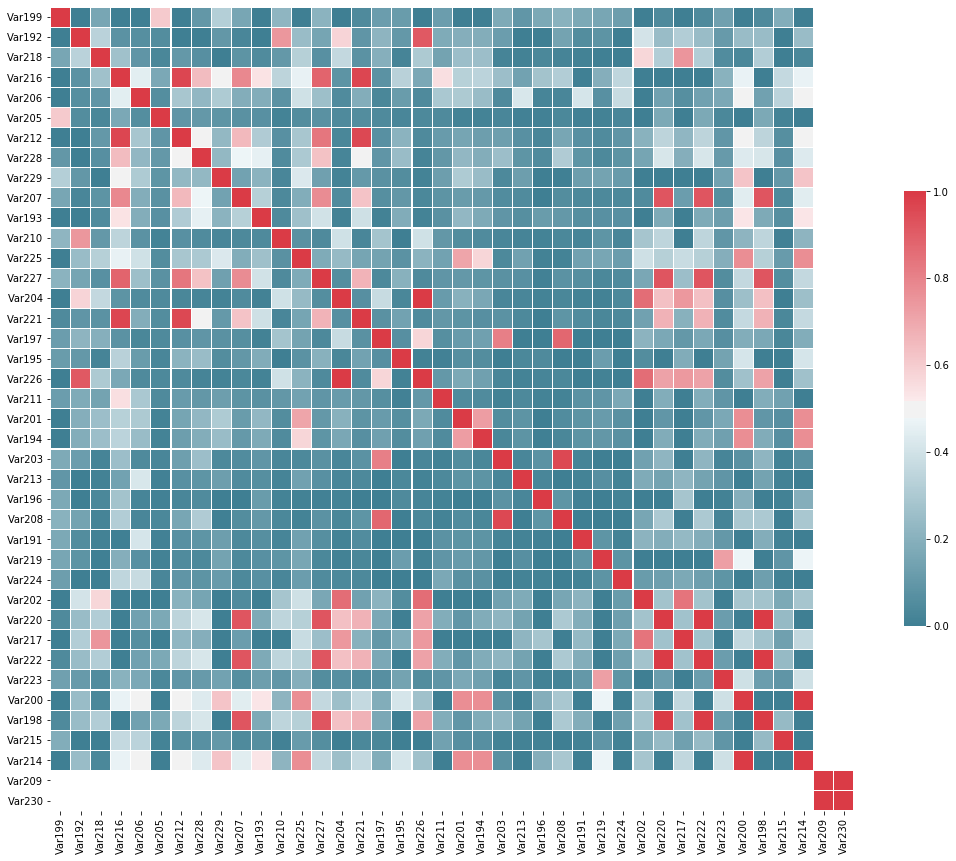

In [272]:
# параметры графика
f, ax = plt.subplots(figsize=(18, 16))

# палитра
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# отрисовка тепловой карты
sns.heatmap(conf_matrix_cor, cmap=cmap, vmax=1.0, vmin=0.0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)

In [273]:
for feat in itertools.combinations(corr_cat_feat, 2):
    if conf_matrix_cor.loc[feat[0], feat[1]] > 0.9:
        print(feat, conf_matrix_cor.loc[feat[0], feat[1]])

('Var192', 'Var226') 0.9167771347643895
('Var216', 'Var212') 0.9672023218419863
('Var216', 'Var221') 0.9655087241377992
('Var212', 'Var221') 0.9587722519198268
('Var207', 'Var220') 0.9229593042399905
('Var207', 'Var222') 0.9229593042399906
('Var207', 'Var198') 0.9229593042399905
('Var227', 'Var220') 0.9228331462404893
('Var227', 'Var222') 0.9228331462404893
('Var227', 'Var198') 0.9228331462404893
('Var204', 'Var226') 0.9978910730672214
('Var203', 'Var208') 0.957326181675236
('Var220', 'Var222') 0.9999999999999996
('Var220', 'Var198') 0.9999999999999994
('Var222', 'Var198') 0.9999999999999998
('Var200', 'Var214') 0.9999999999999988
('Var209', 'Var230') 1.0


In [35]:
#удалим признак 209 и 230 как пустые
corr_cat_feat = list(set(corr_cat_feat) - set(['Var209','Var230']))

In [275]:
#признаки 192,226,204
temp_fear = ['Var192','Var226','Var204']
[(feat,len(data_cat[feat].unique())) for feat in temp_fear] #число уникальных значений категорий включая nan

[('Var192', 326), ('Var226', 23), ('Var204', 100)]

In [276]:
data[temp_fear].isnull().sum() 

Var192    124
Var226      0
Var204      0
dtype: int64

In [36]:
#удалим признак 192 и 204
corr_cat_feat = list(set(corr_cat_feat) - set(['Var192','Var204']))

In [278]:
#признаки 216,212,221
temp_fear = ['Var216','Var212','Var221']
[(feat,len(data_cat[feat].unique())) for feat in temp_fear] #число уникальных значений категорий включая nan

[('Var216', 1247), ('Var212', 71), ('Var221', 7)]

In [279]:
data[temp_fear].isnull().sum() 

Var216    0
Var212    0
Var221    0
dtype: int64

In [37]:
#удалим признаки 216 и 212
corr_cat_feat = list(set(corr_cat_feat) - set(['Var216','Var212']))

In [282]:
#207,220,222,198,227
temp_fear = ['Var207','Var220','Var222','Var198','Var227']
[(feat,len(data_cat[feat].unique())) for feat in temp_fear] #число уникальных значений категорий включая nan

[('Var207', 12),
 ('Var220', 2721),
 ('Var222', 2721),
 ('Var198', 2721),
 ('Var227', 7)]

In [283]:
data[temp_fear].isnull().sum() 

Var207    0
Var220    0
Var222    0
Var198    0
Var227    0
dtype: int64

In [38]:
#удалим признаки 220,222,198
corr_cat_feat = list(set(corr_cat_feat) - set(['Var220','Var222','Var198']))

In [285]:
#203,208
temp_fear = ['Var203','Var208']
[(feat,len(data_cat[feat].unique())) for feat in temp_fear] #число уникальных значений категорий включая nan

[('Var203', 4), ('Var208', 3)]

In [286]:
data[temp_fear].isnull().sum() 

Var203    55
Var208    55
dtype: int64

In [287]:
data_cat['Var203'].value_counts()

0    16585
2     1145
1      513
3       55
Name: Var203, dtype: int64

In [288]:
data_cat['Var208'].value_counts()

0    16888
2     1355
1       55
Name: Var208, dtype: int64

In [39]:
#удалим признаки 208
corr_cat_feat = list(set(corr_cat_feat) - set(['Var208']))

In [290]:
#200,214
temp_fear = ['Var200','Var214']
[(feat,len(data_cat[feat].unique())) for feat in temp_fear] #число уникальных значений категорий включая nan

[('Var200', 7414), ('Var214', 7414)]

In [291]:
data[temp_fear].isnull().sum() 

Var200    9305
Var214    9305
dtype: int64

In [40]:
#удалим оба этих признака
corr_cat_feat = list(set(corr_cat_feat) - set(['Var200','Var214']))

In [41]:
len(corr_cat_feat) #осталось 28 признаков

28

In [42]:
cramer_list = list()
for features in corr_cat_feat:
    confusion_mx = pd.crosstab(target['labels'], data_cat[features])
    cramer_list.append(cramers_corrected_stat(confusion_mx))
len(cramer_list)

28

In [43]:
data_cor_cat = pd.DataFrame(cramer_list, index=corr_cat_feat, columns=['cor_cat'])
data_cor_cat.sort_values(by='cor_cat', ascending=False)[:10] #топ 10 категориальных признаков коррелирующих с целевой переменнй

,cor_cat
Var199,0.270911
Var218,0.112029
Var206,0.079270
Var205,0.077717
Var228,0.068072
Var229,0.061392
Var207,0.060657
Var193,0.058623
Var210,0.057438
Var225,0.057336


In [44]:
corr_cat_feat_top = data_cor_cat.sort_values(by='cor_cat', ascending=False)[:].index
data[corr_cat_feat_top].isnull().sum() 

Var199        2
Var218      269
Var206     1991
Var205      714
Var228        0
Var229    10365
Var207        0
Var193        0
Var210        0
Var225     9571
Var227        0
Var221        0
Var197       55
Var195        0
Var226        0
Var211        0
Var201    13659
Var194    13659
Var203       55
Var213    17910
Var196        0
Var191    17921
Var219     1882
Var224    17989
Var202        1
Var223     1882
Var215    18040
Var217      269
dtype: int64

In [45]:
[(feat,len(data_cat[feat].unique())) for feat in corr_cat_feat_top] #число уникальных значений категорий включая nan

[('Var199', 2639),
 ('Var218', 3),
 ('Var206', 22),
 ('Var205', 4),
 ('Var228', 29),
 ('Var229', 5),
 ('Var207', 12),
 ('Var193', 44),
 ('Var210', 6),
 ('Var225', 4),
 ('Var227', 7),
 ('Var221', 7),
 ('Var197', 207),
 ('Var195', 21),
 ('Var226', 23),
 ('Var211', 2),
 ('Var201', 3),
 ('Var194', 4),
 ('Var203', 4),
 ('Var213', 2),
 ('Var196', 4),
 ('Var191', 2),
 ('Var219', 20),
 ('Var224', 2),
 ('Var202', 4673),
 ('Var223', 5),
 ('Var215', 2),
 ('Var217', 7944)]

In [46]:
#удалим признаки у которых более 2000 различных категориальных значений
list_unique_cat = [(feat,len(data_cat[feat].unique())) for feat in corr_cat_feat_top] #число уникальных значений категорий включая nan
list_unique_cat[0:5]

[('Var199', 2639),
 ('Var218', 3),
 ('Var206', 22),
 ('Var205', 4),
 ('Var228', 29)]

In [47]:
corr_cat_feat_top_filter = list()
for obj in list_unique_cat:
    if (obj[1]>2) & (obj[1]<2000):
        corr_cat_feat_top_filter.append(obj[0])

In [48]:
len(corr_cat_feat_top_filter)

20

# Отбор и преобразование признаков

In [49]:
print(len(corr_num_feat))
print(len(corr_cat_feat_top_filter))

20
20


In [50]:
train_num = data_num_scaled

In [51]:
train_cat = pd.get_dummies(data[corr_cat_feat_top_filter], dummy_na=True) #one-hot кодирование

In [52]:
data_train = pd.concat([train_num, train_cat], axis = 1)
print(data_train.shape)

(18298, 463)


# Построение базовой модели

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score #точность
from sklearn.metrics import roc_auc_score #площадь под кривой
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [198]:
# отделим отложенную выборку
X, X_hold_out, y, y_hold_out = train_test_split(data_train, target['labels'], test_size=0.1, stratify = target)

# разобьем рабочие данные для кросс-валидации, поделим на 9 подвыборок
skf = StratifiedKFold(n_splits=3)

In [75]:
# печатаем метрики по кросс-валидации
def get_cv_roc_pr_rc(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        print('fit_starting...')
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        print('fit_iter_compit!!!')
        y_pred = clf.predict(X.iloc[test,:])
        y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(metrics.roc_auc_score(y.iloc[test], y_pred_prob))
        pr_auc.append(metrics.average_precision_score(y.iloc[test], y_pred_prob))
        precision.append(metrics.precision_score(y.iloc[test], y_pred))
        recall.append(metrics.recall_score(y.iloc[test], y_pred))

    print('ROC-AUC:', np.mean(roc_auc))
    print('PR-AUC:', np.mean(pr_auc))
    print('Precission:', np.mean(precision))
    print('Recall:', np.mean(recall))
    
    return roc_auc, pr_auc, precision, recall, models

In [76]:
def get_result_for_x_hold(clf, X, X_hold_out, y, y_hold_out):
    clf.fit(X,y)
    y_pred = clf.predict(X_hold_out)
    acc = accuracy_score(y_hold_out,y_pred)
    roc_auc = roc_auc_score(y_hold_out,y_pred)
    precision = precision_score(y_hold_out,y_pred)
    recall = recall_score(y_hold_out,y_pred)
    print('ROC-AUC:', roc_auc)
    print('ACC:', acc)
    print('Precission:', precision)
    print('Recall:', recall)
    
    return clf, y_pred

In [322]:
# Логистическая регрессия
clf = LogisticRegression(class_weight='balanced', n_jobs=-1)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, y)

fit_starting...
fit_iter_compit!!!
fit_starting...
fit_iter_compit!!!
fit_starting...
fit_iter_compit!!!
ROC-AUC: 0.6474318309335164
PR-AUC: 0.14265794812457652
Precission: 0.11683509500326082
Recall: 0.5520581113801453


In [323]:
model, y_pred = get_result_for_x_hold(clf, X, X_hold_out, y, y_hold_out)

ROC-AUC: 0.6539469626888683
ACC: 0.66775956284153
Precission: 0.13622291021671826
Recall: 0.6376811594202898


In [321]:
np.unique(y_pred) # модель дает константное предсказание

array([0., 1.])

In [327]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'saga'], 'penalty':['l1', 'l2']}
model = LogisticRegression(class_weight='balanced')
grid_cv = GridSearchCV(model, param_grid, scoring='roc_auc',  cv=skf)
grid_cv.fit(X,y)

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Use

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [331]:
y_pred = grid_cv.predict(X_hold_out)
acc = accuracy_score(y_hold_out,y_pred)
roc_auc = roc_auc_score(y_hold_out,y_pred)
precision = precision_score(y_hold_out,y_pred, pos_label=1)
recall = recall_score(y_hold_out,y_pred)
print('ROC-AUC:', roc_auc)
print('ACC:', acc)
print('Precission:', precision)
print('Recall:', recall)

ROC-AUC: 0.6433086648165278
ACC: 0.6480874316939891
Precission: 0.12903225806451613
Recall: 0.6376811594202898


In [334]:
print(y_pred.mean()*len(y_pred))
print(len(y_pred) - y_pred.mean()*len(y_pred))

682.0
1148.0


In [335]:
print(y_hold_out.mean()*len(y_hold_out))
print(len(y_hold_out) - y_hold_out.mean()*len(y_hold_out))

138.0
1692.0


# Проверка нейронной сети

In [54]:
X, X_hold_out, y, y_hold_out = train_test_split(data_train, target['labels'], test_size=0.1, stratify = target)

In [55]:
X.shape

(16468, 463)

In [78]:
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(463,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(), optimizer='rmsprop', metrics=[tensorflow.keras.metrics.AUC()])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               59392     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(X, y, batch_size=512, epochs=10, validation_data=(X_hold_out, y_hold_out))

Train on 16468 samples, validate on 1830 samples
Epoch 1/10
16468/16468 [==============================] - 2s 96us/sample - loss: 0.3149 - auc_4: 0.5374 - val_loss: 0.2590 - val_auc_4: 0.6617
Epoch 2/10
16468/16468 [==============================] - 0s 21us/sample - loss: 0.2655 - auc_4: 0.6236 - val_loss: 0.2547 - val_auc_4: 0.6762
Epoch 3/10
16468/16468 [==============================] - 0s 20us/sample - loss: 0.2602 - auc_4: 0.6452 - val_loss: 0.2519 - val_auc_4: 0.6767
Epoch 4/10
16468/16468 [==============================] - 0s 20us/sample - loss: 0.2553 - auc_4: 0.6721 - val_loss: 0.2548 - val_auc_4: 0.6679
Epoch 5/10
16468/16468 [==============================] - 0s 20us/sample - loss: 0.2518 - auc_4: 0.6894 - val_loss: 0.2533 - val_auc_4: 0.6649
Epoch 6/10
16468/16468 [==============================] - 0s 20us/sample - loss: 0.2496 - auc_4: 0.6983 - val_loss: 0.2572 - val_auc_4: 0.6672
Epoch 7/10
16468/16468 [==============================] - 0s 20us/sample - loss: 0.2478 - auc

In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'auc_4', 'val_loss', 'val_auc_4'])

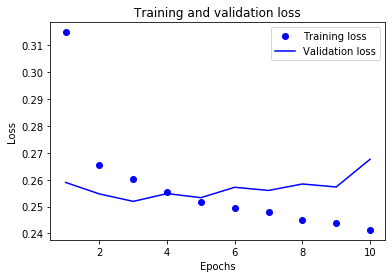

In [81]:
import matplotlib.pyplot as plt
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

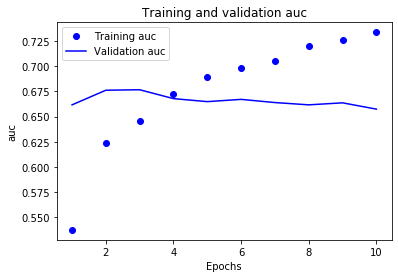

In [83]:
acc_values = history_dict['auc_4']
val_acc_values = history_dict['val_auc_4']
plt.plot(epochs, acc_values, 'bo', label='Training auc')
plt.plot(epochs, val_acc_values, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

Переобучение наблюдается с третей эпохи. Максимальная оценка, которую смогли достигнуть на валидационной выборке составляет 0,675

# Подготовка тестовой выборки

In [84]:
print(test.shape)

(10000, 230)


In [85]:
#отобранные признаки
test_num = test[corr_num_feat]
test_cat = test[corr_cat_feat_top_filter]

In [86]:
#масштабирование численных признаков тестового набора
test_num = test_num[corr_num_feat].fillna(mean_train)
test_num_scaled = scaler.transform(test_num)
test_num_scaled = pd.DataFrame(test_num_scaled, index=test_num.index, columns=test_num.columns)

In [87]:
#обработка категориальных признаков
data[corr_cat_feat_top_filter].shape

(18298, 20)

In [88]:
all_cat_data =pd.concat([data[corr_cat_feat_top_filter],test_cat],axis=0)
all_cat_data_transf = pd.get_dummies(all_cat_data, dummy_na=True) #one-hot кодирование
all_cat_data_transf.shape

(28298, 456)

In [89]:
train_cat_transf = all_cat_data_transf[:18298]
train_cat_list = [(fear,len(train_cat_transf[fear].unique())) for fear in train_cat_transf.columns]
need_cat_fear = list()
for obj in train_cat_list:
    if obj[1]> 1:
        need_cat_fear.append(obj[0])
print(len(need_cat_fear))

434


In [90]:
train_cat_transf = train_cat_transf[need_cat_fear]
test_cat_transf = all_cat_data_transf[need_cat_fear][18298:]

In [91]:
#сбор обработанного тестового набора
test_transf = pd.concat([test_num_scaled,test_cat_transf], axis=1)
test_transf.shape

(10000, 454)

In [92]:
#сбор обработанного тренировочного набора
train_transf = pd.concat([data_num_scaled,train_cat_transf], axis=1)
train_transf.shape

(18298, 454)

## Предсказание логистической регрессии на тестовых данных

In [199]:
# Логистическая регрессия
model = LogisticRegression(class_weight='balanced', n_jobs=-1)
model.fit(train_transf,target['labels'].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [200]:
y_pred_test = model.predict_proba(test_transf)

In [204]:
y_pred_test_prob_1 = [obj[1] for obj in y_pred_test]

In [205]:
answer_df = pd.DataFrame(y_pred_test_prob_1, columns=['result'])
answer_df.index.name = 'ID'
answer_df.to_csv('answer.csv', index='ID') #0.66745 (преодолели simple benchmark)

## Предсказание нейронной сети на тестовых данных

In [130]:
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(128, kernel_regularizer=tensorflow.keras.regularizers.l2(0.001), activation='relu', input_shape=(454,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, kernel_regularizer=tensorflow.keras.regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(), optimizer='rmsprop', metrics=[tensorflow.keras.metrics.AUC()])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               58240     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


In [131]:
X, X_hold_out, y, y_hold_out = train_test_split(train_transf, target['labels'].values, test_size=0.1, stratify = target)

In [132]:
history = model.fit(X, y, batch_size=512, epochs=20, validation_data=(X_hold_out, y_hold_out))

Train on 16468 samples, validate on 1830 samples
Epoch 1/20
16468/16468 [==============================] - 2s 101us/sample - loss: 0.5231 - auc_10: 0.5514 - val_loss: 0.4112 - val_auc_10: 0.6313
Epoch 2/20
16468/16468 [==============================] - 0s 21us/sample - loss: 0.3865 - auc_10: 0.6133 - val_loss: 0.3518 - val_auc_10: 0.6586
Epoch 3/20
16468/16468 [==============================] - 0s 21us/sample - loss: 0.3367 - auc_10: 0.6408 - val_loss: 0.3171 - val_auc_10: 0.6667
Epoch 4/20
16468/16468 [==============================] - 0s 21us/sample - loss: 0.3109 - auc_10: 0.6574 - val_loss: 0.3004 - val_auc_10: 0.6726
Epoch 5/20
16468/16468 [==============================] - 0s 21us/sample - loss: 0.2968 - auc_10: 0.6627 - val_loss: 0.2911 - val_auc_10: 0.6735
Epoch 6/20
16468/16468 [==============================] - 0s 21us/sample - loss: 0.2871 - auc_10: 0.6717 - val_loss: 0.2836 - val_auc_10: 0.6653
Epoch 7/20
16468/16468 [==============================] - 0s 22us/sample - loss:

In [133]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'auc_10', 'val_loss', 'val_auc_10'])

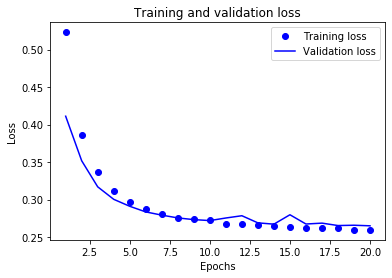

In [134]:
import matplotlib.pyplot as plt
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

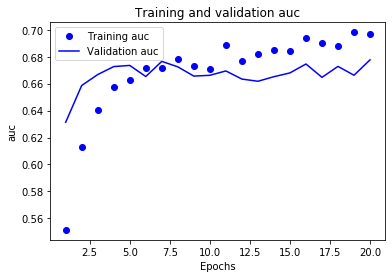

In [136]:
acc_values = history_dict['auc_10']
val_acc_values = history_dict['val_auc_10']
plt.plot(epochs, acc_values, 'bo', label='Training auc')
plt.plot(epochs, val_acc_values, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

In [193]:
model = models.Sequential()
model.add(layers.Dense(128, kernel_regularizer=tensorflow.keras.regularizers.l2(0.001), activation='relu', input_shape=(454,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, kernel_regularizer=tensorflow.keras.regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(), optimizer='rmsprop', metrics=[tensorflow.keras.metrics.AUC()])

model.fit(train_transf, target['labels'].values, epochs=20, batch_size=512)

Train on 18298 samples
Epoch 1/20
18298/18298 [==============================] - 1s 73us/sample - loss: 0.4949 - auc_14: 0.5549
Epoch 2/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.3774 - auc_14: 0.6133
Epoch 3/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.3318 - auc_14: 0.6412
Epoch 4/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.3078 - auc_14: 0.6609
Epoch 5/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.2951 - auc_14: 0.6602
Epoch 6/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.2859 - auc_14: 0.6683
Epoch 7/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.2807 - auc_14: 0.6707
Epoch 8/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.2765 - auc_14: 0.6745
Epoch 9/20
18298/18298 [==============================] - 0s 18us/sample - loss: 0.2727 - auc_14: 0.6784
Epoch 10/20
18298/18298 [=======

In [194]:
predictions = model.predict(test_transf) #предсказание модели

In [195]:
predictions = predictions.reshape(10000)

In [197]:
answer_df = pd.DataFrame(predictions, columns=['result'])
answer_df.index.name = 'ID'
answer_df.to_csv('answer_n_2.csv', index='ID') #0.66 - порог simple benchmark ([оценка хуже, чем  линейной регрессии])